In [1]:
import os
import sys
sys.path.append('..')
import shelve

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2
from tqdm import tqdm

from scripts.analysis.DBInfo import DBInfo
from scripts.analysis import build_loci
from scripts import utils

BASE = '../data'

db_info = DBInfo("compil_mgm")
metadata = build_loci.read_metadata(os.path.join(BASE,"time_metadata.csv"))

In [2]:
metadata = metadata.T.sort_values(['col_date', 'n15']).T

In [3]:
samples = shelve.open(os.path.join(BASE,"Time_samples.shelve"))
for sample_name, sample_info in tqdm(list(metadata.iteritems())):
    if sample_name not in samples.keys():
        sample = build_loci.Sample(sample_name, sample_info.path, db_info, sample_info)
        samples[sample.sample_name] = sample

100%|██████████| 12/12 [00:00<00:00, 120.63it/s]


In [4]:
protein_clusters = shelve.open(os.path.join(BASE, 'Time_protein_clusters.shelve'))

for name, sample in tqdm(samples.items()):
    if name not in protein_clusters.keys():
        protein_clusters[name] = sample.build_protein_clusters()


100%|██████████| 12/12 [00:04<00:00,  2.92it/s]


In [8]:
metadata = metadata.T
metadata['enrich_path'] = metadata['path'].str.replace('/dta-pfp-0.01/DTASelect-filter.txt', '/census-out.txt')
metadata['enrich_path'][0]

'/Users/mmayers/projects/n15_mice/data/20151209-UnerFecal-Lys-N14N15-1016/rawXtractor/census-out.txt'

In [9]:
import scripts.census_parser as cp

In [88]:
peps = []
prots = []
samp_type = {'UL_Mix_1021_1': '1 Week', 'UL_Mix_1019_1': '4 Days', 'UL_Mix_1016_1': '1 Day',
             'UL_Mix_1121_2': '6 Weeks', 'UL_Mix_1111_1': '4 Weeks', 'UL_Mix_Pool_1': 'Pooled Samples',
             'UL_Mix_1021_N_1': '1 Week', 'UL_Mix_1019_N_1': '4 Days', 'UL_Mix_1016_N_1': '1 Day',
             'UL_Mix_1121_N_2': '6 Weeks', 'UL_Mix_1111_N_1': '4 Weeks', 'UL_Mix_Pool_N_1': 'Pooled Samples'}
for path, sample in zip(metadata['enrich_path'][::2], metadata.index.tolist()[::2]):
    p, s = cp.parse_file(path, enrichment=True)
    s['samp'] = samp_type[sample]
    # make sure to drop duplicates, sequence and charge state should be enough to differentiate
    s = s.drop_duplicates(subset=['sequence', 'cs']) 
    peps.append(s.query('enrichment > .6'))
    prots.append(p)

In [54]:
enrichment = pd.concat(peps)

In [55]:
for samp in sorted(samp_type.values(), key=lambda x: (x.split(' ')[1], x.split(' ')[0])):
    median_enr = enrichment.query('samp == "{}"'.format(samp))['enrichment'].median()
    if samp != 'Pooled Samples':
        print("Sample: {}\t Enrichment: {}".format(samp, median_enr))

Sample: 1 Day	 Enrichment: 0.85
Sample: 1 Day	 Enrichment: 0.85
Sample: 4 Days	 Enrichment: 0.86
Sample: 4 Days	 Enrichment: 0.86
Sample: 1 Week	 Enrichment: 0.88
Sample: 1 Week	 Enrichment: 0.88
Sample: 4 Weeks	 Enrichment: 0.94
Sample: 4 Weeks	 Enrichment: 0.94
Sample: 6 Weeks	 Enrichment: 0.96
Sample: 6 Weeks	 Enrichment: 0.96


In [93]:
for samp, kind in sorted(samp_type.items(), key=lambda x: (x[1].split(' ')[1], x[1].split(' ')[0])):
    if kind != "Pooled Samples":
        print(kind, samp, 'Peptides', len(set(samples[samp].peptides)), 'Proteins', len(protein_clusters[samp]))

1 Day UL_Mix_1016_1 Peptides 5375 Proteins 4296
1 Day UL_Mix_1016_N_1 Peptides 655 Proteins 683
4 Days UL_Mix_1019_1 Peptides 2221 Proteins 1578
4 Days UL_Mix_1019_N_1 Peptides 724 Proteins 510
1 Week UL_Mix_1021_1 Peptides 5691 Proteins 4744
1 Week UL_Mix_1021_N_1 Peptides 2061 Proteins 2014
4 Weeks UL_Mix_1111_1 Peptides 1591 Proteins 672
4 Weeks UL_Mix_1111_N_1 Peptides 1247 Proteins 596
6 Weeks UL_Mix_1121_2 Peptides 2194 Proteins 1197
6 Weeks UL_Mix_1121_N_2 Peptides 1687 Proteins 1000


In [57]:
pps = set()
for samp, kind in sorted(samp_type.items(), key=lambda x: (x[1].split(' ')[1], x[1].split(' ')[0])):
    if kind == "1 Day":
        pps.update(set(samples[samp].peptides))
print('Numb peps in both N14 and N15 Day 1:\t', len(pps))

Numb peps in both N14 and N15 Day 1:	 5508


In [83]:
print('Number of quantifiable pepties per sample:')
for samp in sorted(samp_type.values(), key=lambda x: (x.split(' ')[1], x.split(' ')[0]))[::2]:
    print(samp, len(enrichment.query('samp == "{}"'.format(samp))))

Number of quantifiable pepties per sample:
1 Day 181
4 Days 569
Pooled Samples 1248
1 Week 993
4 Weeks 923
6 Weeks 1135


In [99]:
print('Number of protein clusters containing quantifyable peptides: ')
for samp, kind in sorted(samp_type.items(), key=lambda x: (x[1].split(' ')[1], x[1].split(' ')[0]))[::2]:
    
    # Ugly line, gets a set of the quantifyable pepties in the given sample type
    peps1 = set([x[0].split('.')[1] for x in list(map(utils.get_unmod_seq, list(enrichment.query("samp == '{}'".format(kind))['sequence'])))])
    
    n15_samp = '_'.join(samp.split('_')[:-1]) + '_N_'+ samp.split('_')[-1]
    
    # Get all peptides from both n14 and n15 samples 
    peps2 = samples[samp].peptides 
    peps3 = samples[n15_samp].peptides
    # Build the loci from all these peptides
    # loci 1 = n14+n15 peptides, loci2 = n14 pepides, loci3 = n15 peptides
    loci1 = build_loci.build_loci_from_all_peptides(peps2|peps3)
    loci2 = build_loci.build_loci_from_all_peptides(peps2)
    loci3 = build_loci.build_loci_from_all_peptides(peps3)

    # Count which protein clusters contain these quantifiyable peptides
    num_loc1 = 0
    for locus in loci1:
        if len(locus['peptide_seq'] & peps1) != 0:
            num_loc1 += 1
    
    num_loc2 = 0
    for locus in loci2:
        if len(locus['peptide_seq'] & peps1) != 0:
            num_loc2 += 1
            
    num_loc3 = 0
    for locus in loci3:
        if len(locus['peptide_seq'] & peps1) != 0:
            num_loc3 += 1
    
    
    
    print(samp_type[samp], ':\tBoth: ', num_loc1, 'N14: ', num_loc2, 'N15: ', num_loc3)


Number of protein clusters containing quantifyable peptides: 
1 Day : 	Both:  592 N14:  589 N15:  80
4 Days : 	Both:  351 N14:  343 N15:  128
Pooled Samples : 	Both:  527 N14:  508 N15:  332
1 Week : 	Both:  1213 N14:  1179 N15:  497
4 Weeks : 	Both:  201 N14:  179 N15:  147
6 Weeks : 	Both:  436 N14:  383 N15:  349


In [70]:
peps = set([x[0].split('.')[1] for x in list(map(utils.get_unmod_seq, list(enrichment.query("samp == '4 Days'")['sequence'])))])

loci = build_loci.build_loci_from_all_peptides(peps)

len(loci)

84

In [69]:
peps = set([x[0].split('.')[1] for x in list(map(utils.get_unmod_seq, list(enrichment.query("samp == '1 Week'")['sequence'])))])

loci = build_loci.build_loci_from_all_peptides(peps)

len(loci)

202

In [71]:
peps = set([x[0].split('.')[1] for x in list(map(utils.get_unmod_seq, list(enrichment.query("samp == '4 Weeks'")['sequence'])))])

loci = build_loci.build_loci_from_all_peptides(peps)

len(loci)

102

In [72]:
peps = set([x[0].split('.')[1] for x in list(map(utils.get_unmod_seq, list(enrichment.query("samp == '6 Weeks'")['sequence'])))])

loci = build_loci.build_loci_from_all_peptides(peps)

len(loci)

182

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


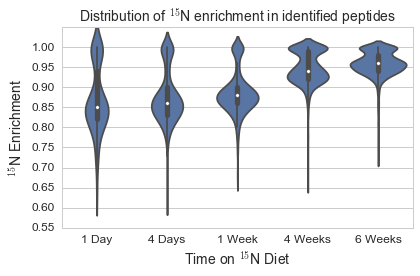

In [60]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 4)
sns.violinplot(data = enrichment.query('samp != "Pooled Samples"'), x = 'samp', y = 'enrichment', palette=[sns.color_palette()[0]]*6)
plt.yticks(np.arange(.5, 1.05, .05), size=12)
plt.xticks(size = 12)
plt.ylim([.55, 1.05])
plt.title('Distribution of ${}^{15}$N enrichment in identified peptides', size = 14)
plt.xlabel('Time on ${}^{15}$N Diet', size = 14)
plt.ylabel('${}^{15}$N Enrichment', size = 14);
plt.savefig('Enrichment_violin.svg')

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


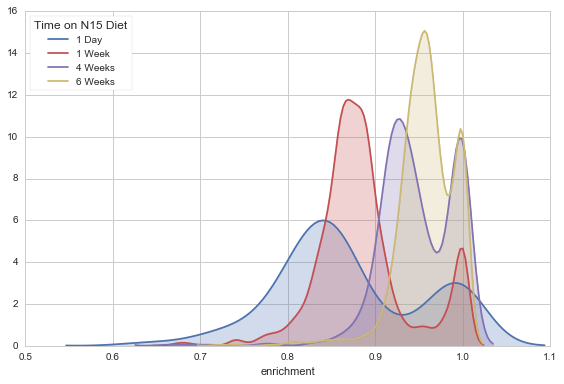

In [89]:
sns.distplot(peps[0]['enrichment'], hist = False, kde_kws={'shade':True}, label = '1 Day');
sns.distplot(peps[2]['enrichment'], hist = False, kde_kws={'shade':True}, label = '1 Week', color = sns.color_palette()[2]);
sns.distplot(peps[3]['enrichment'], hist = False, kde_kws={'shade':True}, label = '4 Weeks', color = sns.color_palette()[3]);
sns.distplot(peps[4]['enrichment'], hist = False, kde_kws={'shade':True}, label = '6 Weeks', color = sns.color_palette()[4]);
plt.legend(title='Time on N15 Diet', loc = 2, frameon = True);

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


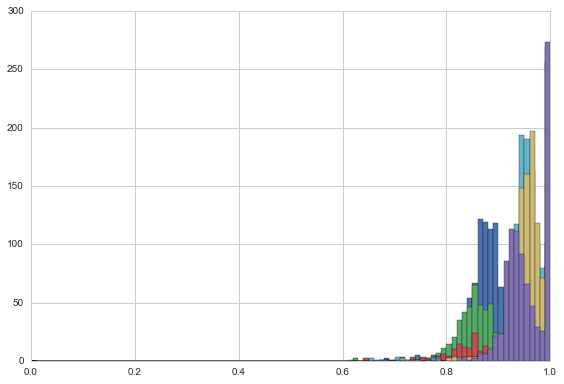

In [90]:
sns.set_style('whitegrid')
plt.hist(peps[2]['enrichment'].dropna(), bins = 100,  range = (0,1), color = sns.color_palette()[0]); # 1 Week
plt.hist(peps[1]['enrichment'].dropna(), bins = 100,  range = (0,1), color = sns.color_palette()[1]); # 4 Days
plt.hist(peps[0]['enrichment'].dropna(), bins = 100,  range = (0,1), color = sns.color_palette()[2]); # 1 Day
plt.hist(peps[5]['enrichment'].dropna(), bins = 100,  range = (0,1), color = sns.color_palette()[5]); # Pool
plt.hist(peps[4]['enrichment'].dropna(), bins = 100,  range = (0,1), color = sns.color_palette()[4]); # 6 Weeks
plt.hist(peps[3]['enrichment'].dropna(), bins = 100,  range = (0,1), color = sns.color_palette()[3]); # 4 Weeks


In [100]:
sample_pairs = metadata.reset_index().set_index(['enriched', 'col_date']).sort_index().groupby(level=[0,1])

pairs = []
for x, y in sample_pairs:
    pairs.append(list(y['index'].values))
pairs

[['UL_Mix_1016_1', 'UL_Mix_1016_N_1'],
 ['UL_Mix_1019_1', 'UL_Mix_1019_N_1'],
 ['UL_Mix_1021_1', 'UL_Mix_1021_N_1'],
 ['UL_Mix_1111_1', 'UL_Mix_1111_N_1'],
 ['UL_Mix_1121_2', 'UL_Mix_1121_N_2'],
 ['UL_Mix_Pool_1', 'UL_Mix_Pool_N_1']]

In [101]:
loci = []
for pair in pairs:
    n14 = set(prot.cluster_id for prot in protein_clusters[pair[0]])
    n15 = set(prot.cluster_id for prot in protein_clusters[pair[1]])
    
    loci.append((n14, n15))

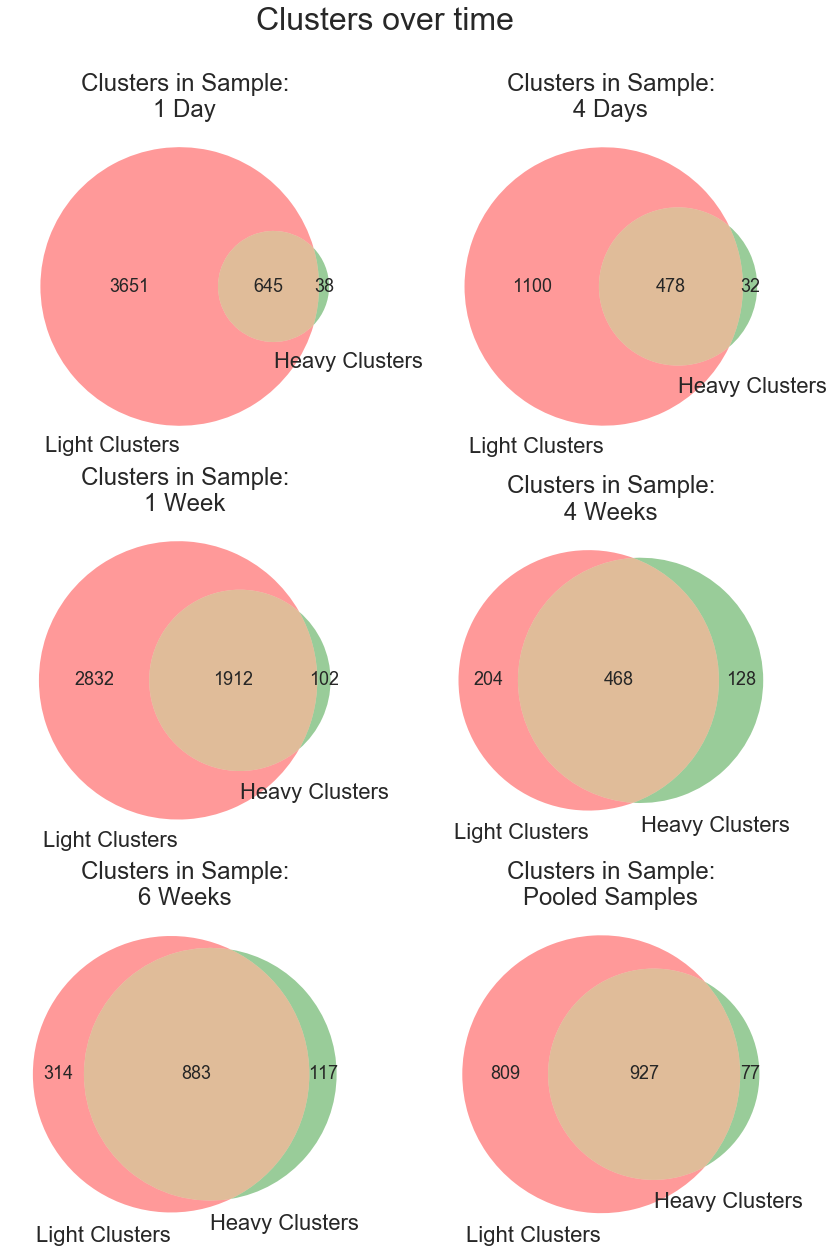

In [102]:
rows = len(pairs) // 2

fig, ax = plt.subplots(rows, 2)
fig.set_tight_layout(False)
fig.set_size_inches(14, 20)
fig.suptitle('Clusters over time', size = 32)

for i, (locus, pair) in enumerate(zip(loci, pairs)):
    v = venn2([locus[0], locus[1]], ['Light Clusters', 'Heavy Clusters'], ax = ax[i//2][i%2])
    
    for txt in v.set_labels:
        txt.set_fontsize(22)
    for text in v.subset_labels:
        text.set_fontsize(18)
    ax[i//2][i%2].set_title('Clusters in Sample:\n{}'.format(samp_type[pair[0]]), size = 24)

In [103]:
loci_info = dict()
for l, pair in zip(loci, pairs):
    d = {pair[0] : {'total': len(l[0] | l[1]), 'n14': len(l[0] - l[1]), 
                    'n15': len(l[1] - l[0]), 'ins': len(l[0] & l[1])}}
         
    loci_info.update(d)   

venn_data = pd.DataFrame.from_dict(loci_info).T
venn_data = venn_data[['n14', 'ins', 'n15', 'total']]

venn_data = venn_data.rename(index=samp_type, columns={'total': 'Total Loci', 'n14': 'N14 Loci', 'n15': 'N15 Loci', 'ins': 'Loci in Both'})
venn_data.iloc[:-1]

,N14 Loci,Loci in Both,N15 Loci,Total Loci
1 Day,3651,645,38,4334
4 Days,1100,478,32,1610
1 Week,2832,1912,102,4846
4 Weeks,204,468,128,800
6 Weeks,314,883,117,1314


In [104]:
from itertools import chain
"""
# To build on first Run
sample_pep_quant = {name: samp.pep_quant for name, samp in samples.items()}
sample_quant_dict = {name: samp['n15'] for name, samp in samples.items()}

grouped_loci = build_loci.group_across_samples(list(chain(*protein_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(grouped_loci):
    locus.annotate()
    #locus.quantify(rt_un_keys_f) #Only quantify ratios across N14 identifications

utils.save(grouped_loci, os.path.join(BASE,"Time_grouped_loci.pkl.gz"), force=True)
"""
# To load on future runs
grouped_loci = utils.load(os.path.join(BASE, "Time_grouped_loci.pkl.gz"))

In [105]:
# This code should probably be somewhere else
def get_gene_name(r):
    if r.find('GN=') > 0:
        return r[r.index('GN=')+3:].split(' ')[0]
    else:
        return ''

    
def get_genus(r):
    if r.find('OS=') > 0:
        return r[r.index('OS=')+3:].split(' ')[0]
    else:
        return ''

In [106]:
def get_count_prots(quant):
    out = dict()
    for samp in list(chain(*pairs)):
        if samp in quant.keys():
            out[samp] = quant[samp]['counts']
        else:
            out[samp] = np.nan
    return out

In [107]:
def count_only_dict(grouped_loci):
    prots = []
    for prot in grouped_loci:
        protd = {'id': prot.cluster_id,
                'name': prot.name,
                'lca': prot.lca,
                'lca_organism': prot.lca_organism,
                'gene': get_gene_name(prot.name),
                'genus': get_genus(prot.name),
                'spir': any(['Arthrospira' in inf['d'] for inf in prot.prot_info])}
        protd.update(get_count_prots(prot.quantification))
        prots.append(protd)
    return prots

In [108]:
dat1 = pd.DataFrame(count_only_dict(grouped_loci))

In [109]:
samp_names = list(chain(*pairs))

In [110]:
summary1 = dat1[samp_names].replace(0, np.nan).count().to_frame()
summary1 = summary1.rename(columns={0: "total_clust"})
summary1['clust_with_raito'] =  dat1[samp_names].count()

In [111]:
summary1['total_counts'] = dat1[samp_names].sum()
summary1['mouse_clust'] = dat1.query('lca == 10090 or genus == "Mus"')[samp_names].replace(0, np.nan).count()
summary1['spir_clust'] = dat1.query("genus == 'Arthrospira' or lca in [35823, 1150, 118562] or spir == True")[samp_names].replace(0, np.nan).count()
summary1['mouse_counts'] = dat1.query('lca == 10090 or genus == "Mus"')[samp_names].sum()
summary1['spir_counts'] = dat1.query("genus == 'Arthrospira' or lca in [35823, 1150, 118562] or spir == True")[samp_names].sum()

summary1['mouse_ratio_c'] = summary1['mouse_counts'] / summary1['total_counts']
summary1['spir_ratio_c'] = summary1['spir_counts'] / summary1['total_counts']
summary1['remain_c'] = 1 - summary1['mouse_ratio_c'] - summary1['spir_ratio_c']
summary1['spir_ratio_l'] = summary1['spir_clust'] / summary1['total_clust']
summary1['mouse_ratio_l'] = summary1['mouse_clust'] / summary1['total_clust']
summary1['remain_l'] = 1 - summary1['mouse_ratio_l'] - summary1['spir_ratio_l']


In [112]:
summary1

,total_clust,clust_with_raito,total_counts,mouse_clust,spir_clust,mouse_counts,spir_counts,mouse_ratio_c,spir_ratio_c,remain_c,spir_ratio_l,mouse_ratio_l,remain_l
UL_Mix_1016_1,5278,5304,144172.0,145,17,5252.0,1590.0,0.036429,0.011028,0.952543,0.003221,0.027473,0.969307
UL_Mix_1016_N_1,269,1965,8987.0,1,48,5.0,6489.0,0.000556,0.722043,0.277401,0.178439,0.003717,0.817844
UL_Mix_1019_1,3182,3218,57051.0,115,20,4358.0,2350.0,0.076388,0.041191,0.882421,0.006285,0.036141,0.957574
UL_Mix_1019_N_1,559,2006,9701.0,10,36,132.0,6292.0,0.013607,0.648593,0.337800,0.064401,0.017889,0.917710
UL_Mix_1021_1,5592,5653,146980.0,126,29,6549.0,3152.0,0.044557,0.021445,0.933998,0.005186,0.022532,0.972282
UL_Mix_1021_N_1,1508,3990,18868.0,40,65,855.0,8127.0,0.045315,0.430729,0.523956,0.043103,0.026525,0.930371
UL_Mix_1111_1,1288,1830,27575.0,120,41,9956.0,3618.0,0.361052,0.131206,0.507743,0.031832,0.093168,0.875000
UL_Mix_1111_N_1,1283,1808,19262.0,54,55,2420.0,6711.0,0.125636,0.348406,0.525958,0.042868,0.042089,0.915043
UL_Mix_1121_2,2468,2699,38998.0,124,34,9897.0,2488.0,0.253782,0.063798,0.682420,0.013776,0.050243,0.935981
UL_Mix_1121_N_2,1996,2608,28643.0,55,47,3374.0,6189.0,0.117795,0.216074,0.666131,0.023547,0.027555,0.948898


In [113]:
n14_samps = [pair[0] for pair in pairs]
n15_samps = [pair[1] for pair in pairs]

In [114]:
def plot_stacked_bar(smps, title):

    sns.set_style('white')
    df = summary1.loc[smps]
    X = np.arange(len(df))
    
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(6, 4.5)
    
    p1 = plt.bar(X, df['mouse_ratio_c'])
    p2 = plt.bar(X, df['spir_ratio_c'], bottom = df['mouse_ratio_c'], color = sns.color_palette()[1])
    p3 = plt.bar(X, df['remain_c'], bottom = df['mouse_ratio_c']+df['spir_ratio_c'], color = sns.color_palette()[2])
    plt.xticks(X + .8/2., [samp_type[s] for s in smps], size=12)
    plt.yticks(size=12)
    plt.ylabel('Fraction of Spectral Counts', size=14)
    plt.xlabel('Time on ${}^{15}$N Diet', size=14)
    plt.legend([p3[0], p2[0], p1[0]],['Microbiome', 'Spirulina', 'Mouse'], frameon=True, prop={'size':12})
    plt.title(title, size=14)
    plt.savefig(title.replace(' ', '-') + '.svg')

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


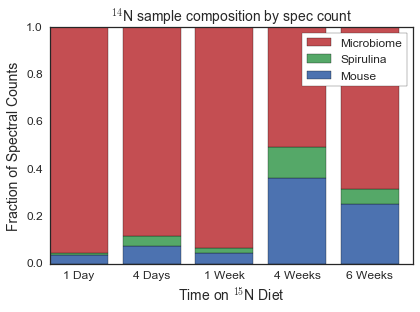

In [115]:
plot_stacked_bar(n14_samps[:-1], '${}^{14}$N sample composition by spec count')

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


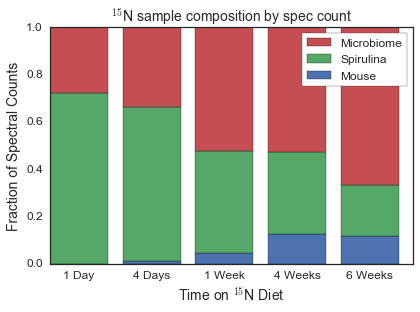

In [116]:
plot_stacked_bar(n15_samps[:-1], '${}^{15}$N sample composition by spec count')

In [117]:
def plot_locus_bar(smps, title):

    sns.set_style('white')
    df = summary1.loc[smps]
    X = np.arange(len(df))

    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(6, 4.5)
    
    p1 = plt.bar(X, df['mouse_ratio_l'])
    p2 = plt.bar(X, df['spir_ratio_l'], bottom = df['mouse_ratio_l'], color = sns.color_palette()[1])
    p3 = plt.bar(X, df['remain_l'], bottom = df['mouse_ratio_l']+df['spir_ratio_l'], color = sns.color_palette()[2])
    plt.xticks(X + .8/2., [samp_type[s] for s in smps], size=12)
    plt.yticks(size=12)
    plt.ylabel('Fraction of Identified Loci', size=14)
    plt.xlabel('Time on ${}^{15}$N Diet', size=14)
    plt.legend([p3[0], p2[0], p1[0]],['Microbiome', 'Spirulina', 'Mouse'], frameon=True, prop={'size': 12})
    plt.title(title, size=14)
    plt.savefig(title.replace(' ', '-')+'.svg')

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


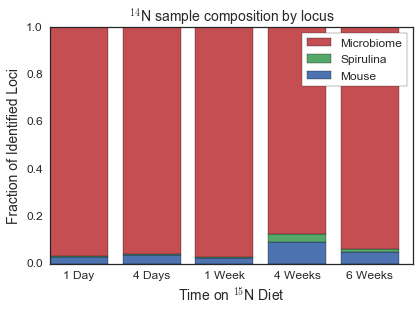

In [118]:
plot_locus_bar(n14_samps[:-1], '${}^{14}$N sample composition by locus')

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


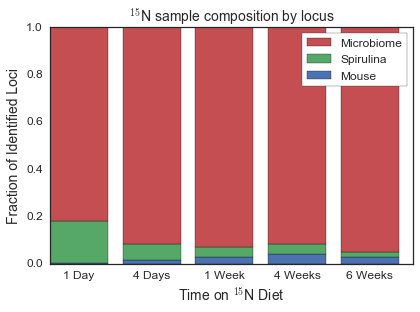

In [119]:
plot_locus_bar(n15_samps[:-1], '${}^{15}$N sample composition by locus')

In [126]:
summary1.loc[n15_samps]

,total_clust,clust_with_raito,total_counts,mouse_clust,spir_clust,mouse_counts,spir_counts,mouse_ratio_c,spir_ratio_c,remain_c,spir_ratio_l,mouse_ratio_l,remain_l
UL_Mix_1016_N_1,269,1965,8987.0,1,48,5.0,6489.0,0.000556,0.722043,0.277401,0.178439,0.003717,0.817844
UL_Mix_1019_N_1,559,2006,9701.0,10,36,132.0,6292.0,0.013607,0.648593,0.337800,0.064401,0.017889,0.917710
UL_Mix_1021_N_1,1508,3990,18868.0,40,65,855.0,8127.0,0.045315,0.430729,0.523956,0.043103,0.026525,0.930371
UL_Mix_1111_N_1,1283,1808,19262.0,54,55,2420.0,6711.0,0.125636,0.348406,0.525958,0.042868,0.042089,0.915043
UL_Mix_1121_N_2,1996,2608,28643.0,55,47,3374.0,6189.0,0.117795,0.216074,0.666131,0.023547,0.027555,0.948898
UL_Mix_Pool_N_1,1410,2737,15828.0,57,45,2334.0,4743.0,0.147460,0.299659,0.552881,0.031915,0.040426,0.927660
